# Weather Classification- Good Day for a BBQ?

### Lynn Anderson

# Overview

The objective of this project was to find the best classification model for predicting good bbq weather. Regression and classification models are both supervised learning algorithms that use one or more independent variables to build models that predict some response. While regression is useful when a target variable is continuous, classification is used for situations where the target variable is labelled into two or more discrete values. In this case, the target variable had two values- True and False- indicationg whether or not that specefic day was suitable weather for an outdoor bbq. In addition to building a model that could best predict the outcomes, I aimed to find the most important weather factors in determining the outcome.


# Business Understanding

All Fired Up is a renowned barbeque and grill restaurant located in London, UK. They serve food from their kitchen every day, and recently added on an outdoor area featuring freshly grilled food from hardwood lump charcoal. Their outdoor charcoal grilled foods have quickly become a huge hit, and on certain days get lots of business. However, on many other days, hardly any people line up outside, or the grills fail to run properly. Weather seems to be a huge factor, so they would like to know more about what weather is ideal for running the outdoor bbq area. Setting up the outdoor charcoal grills take a lot of time and resources, so it is only worth it to fire up the charcoal and run the grill if it is going to be a nice day for barbequing. Otherwise, there is a significant loss on the days they prepare for outdoor grilling but are unsuccessful. However, they also lose out on profits by not running the outdoor grill, since it attracts many more customers and they can charge a higher price. 

Thus, it will be important for my classification model to have a very low rate of false positive errors (ie a predicted 'good' day that is actually not suitable for a bbq), but not entirely at the expense of a large number of false negatives. For my evaluation metric, I am primarily concerned with the F1 score, which represents the harmonic mean of the precesion and recallThe F1 score reflects the model's ability to ability to both capture positive cases (recall) and be accurate with the cases it does capture (precision). Furthermore, it is a better metric on imbalanced datasets than accuracy or AUC. I will also be considering precision when evaluating models, since a high precision indicates the model predicts few false positives. 


# Data Understanding

The dataset consisted of two csv files- one containing records for in different cities, and the other with boolean values for whether it was a good day for an outdoor bbq. The data was sourced from https://www.kaggle.com/datasets/thedevastator/weather-prediction. Both files contained 3,654 entries, each representing a day that weather information was recorded. The dates span between 2000 and 2010, and initially contained information for 18 different European cities. I was only interested in data related to the Heathrow meteorological stations, so removed irrelevant columns and merged the two dataframes before performing any exploratory analysis or modeling. 

# Data Preparation

In [7]:
!pip install shap

In [8]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, f1_score, confusion_matrix, mean_squared_error, roc_curve, auc,
    ConfusionMatrixDisplay)
from sklearn.feature_selection import (VarianceThreshold, SelectKBest, f_regression, mutual_info_regression, 
    RFE, RFECV)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
# read in weather records 
df = pd.read_csv('data/weather_prediction_dataset.csv')
df.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


Each entry contains weather related data for 18 different locations from a specific date.

In [10]:
# read in associated bbq labels
df_labels = pd.read_csv('data/weather_prediction_bbq_labels.csv')
df_labels.head()

,DATE,BASEL_BBQ_weather,BUDAPEST_BBQ_weather,DE_BBQ_weather,DRESDEN_BBQ_weather,DUSSELDORF_BBQ_weather,HEATHROW_BBQ_weather,KASSEL_BBQ_weather,LJUBLJANA_BBQ_weather,MAASTRICHT_BBQ_weather,MALMO_BBQ_weather,MONTELIMAR_BBQ_weather,MUENCHEN_BBQ_weather,OSLO_BBQ_weather,PERPIGNAN_BBQ_weather,SONNBLICK_BBQ_weather,STOCKHOLM_BBQ_weather,TOURS_BBQ_weather
0,20000101,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,20000102,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,20000103,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,20000104,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,20000105,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Each entry contains information regarding whether or not it was suitable for a bbq in a specific location on that day.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Columns: 165 entries, DATE to TOURS_temp_max
dtypes: float64(150), int64(15)
memory usage: 4.6 MB


The full dataset contains 165 columns and 3,654 rows. Before any exploratory analysis or modeling, I will be removing columns not pertaining to Heathrow weather.

In [12]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   DATE                    3654 non-null   int64
 1   BASEL_BBQ_weather       3654 non-null   bool 
 2   BUDAPEST_BBQ_weather    3654 non-null   bool 
 3   DE_BBQ_weather          3654 non-null   bool 
 4   DRESDEN_BBQ_weather     3654 non-null   bool 
 5   DUSSELDORF_BBQ_weather  3654 non-null   bool 
 6   HEATHROW_BBQ_weather    3654 non-null   bool 
 7   KASSEL_BBQ_weather      3654 non-null   bool 
 8   LJUBLJANA_BBQ_weather   3654 non-null   bool 
 9   MAASTRICHT_BBQ_weather  3654 non-null   bool 
 10  MALMO_BBQ_weather       3654 non-null   bool 
 11  MONTELIMAR_BBQ_weather  3654 non-null   bool 
 12  MUENCHEN_BBQ_weather    3654 non-null   bool 
 13  OSLO_BBQ_weather        3654 non-null   bool 
 14  PERPIGNAN_BBQ_weather   3654 non-null   bool 
 15  SONNBLICK_BBQ_weather

I will be looking at Heathrow bbq weather as my target variable. All values besides date are of type boolean. 

In [13]:
# investigate all columns
list(df.columns)

['DATE',
 'MONTH',
 'BASEL_cloud_cover',
 'BASEL_humidity',
 'BASEL_pressure',
 'BASEL_global_radiation',
 'BASEL_precipitation',
 'BASEL_sunshine',
 'BASEL_temp_mean',
 'BASEL_temp_min',
 'BASEL_temp_max',
 'BUDAPEST_cloud_cover',
 'BUDAPEST_humidity',
 'BUDAPEST_pressure',
 'BUDAPEST_global_radiation',
 'BUDAPEST_precipitation',
 'BUDAPEST_sunshine',
 'BUDAPEST_temp_mean',
 'BUDAPEST_temp_max',
 'DE_BILT_cloud_cover',
 'DE_BILT_wind_speed',
 'DE_BILT_wind_gust',
 'DE_BILT_humidity',
 'DE_BILT_pressure',
 'DE_BILT_global_radiation',
 'DE_BILT_precipitation',
 'DE_BILT_sunshine',
 'DE_BILT_temp_mean',
 'DE_BILT_temp_min',
 'DE_BILT_temp_max',
 'DRESDEN_cloud_cover',
 'DRESDEN_wind_speed',
 'DRESDEN_wind_gust',
 'DRESDEN_humidity',
 'DRESDEN_global_radiation',
 'DRESDEN_precipitation',
 'DRESDEN_sunshine',
 'DRESDEN_temp_mean',
 'DRESDEN_temp_min',
 'DRESDEN_temp_max',
 'DUSSELDORF_cloud_cover',
 'DUSSELDORF_wind_speed',
 'DUSSELDORF_wind_gust',
 'DUSSELDORF_humidity',
 'DUSSELDORF_pres

I am interested in the columns containing data for Heathrow. I will select only those and make a new dataframe, and subsequently merge in the target column from the labels dataframe, joining via the date column.

In [14]:
# dataframe with only info pertaining to Heathrow

base_df_heathrow = df[['DATE', 'MONTH', 'HEATHROW_cloud_cover', 'HEATHROW_humidity', 'HEATHROW_pressure',
                 'HEATHROW_global_radiation', 'HEATHROW_precipitation', 'HEATHROW_sunshine', 'HEATHROW_temp_mean',
                 'HEATHROW_temp_min', 'HEATHROW_temp_max']]

# add HEATHROW_BBQ_weather column to dataframe, joining on "DATE" column

base_df_heathrow = base_df_heathrow.merge(df_labels[['HEATHROW_BBQ_weather', "DATE"]], on="DATE", how="left")
base_df_heathrow.head()

,DATE,MONTH,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_BBQ_weather
0,20000101,1,7,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8,False
1,20000102,1,7,0.89,1.0253,0.20,0.02,0.7,7.9,5.0,11.5,False
2,20000103,1,8,0.91,1.0186,0.13,0.60,0.0,9.4,7.2,9.5,False
3,20000104,1,5,0.89,1.0148,0.34,0.02,2.9,7.0,4.4,11.0,False
4,20000105,1,5,0.85,1.0142,0.25,0.08,1.3,6.4,1.9,10.8,False


Now I have a dataframe containing all relevant information.

In [15]:
# check datatypes
base_df_heathrow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3654 entries, 0 to 3653
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DATE                       3654 non-null   int64  
 1   MONTH                      3654 non-null   int64  
 2   HEATHROW_cloud_cover       3654 non-null   int64  
 3   HEATHROW_humidity          3654 non-null   float64
 4   HEATHROW_pressure          3654 non-null   float64
 5   HEATHROW_global_radiation  3654 non-null   float64
 6   HEATHROW_precipitation     3654 non-null   float64
 7   HEATHROW_sunshine          3654 non-null   float64
 8   HEATHROW_temp_mean         3654 non-null   float64
 9   HEATHROW_temp_min          3654 non-null   float64
 10  HEATHROW_temp_max          3654 non-null   float64
 11  HEATHROW_BBQ_weather       3654 non-null   bool   
dtypes: bool(1), float64(8), int64(3)
memory usage: 346.1 KB


All columns are numeric except for the target variable, which is a boolean. However, the month column should be categorical, as assigning numeric values to the months could interfere with the modeling. I will replace the numbers with the appropriate month names.

In [16]:
#check for null values
base_df_heathrow.isnull().sum()

DATE                         0
MONTH                        0
HEATHROW_cloud_cover         0
HEATHROW_humidity            0
HEATHROW_pressure            0
HEATHROW_global_radiation    0
HEATHROW_precipitation       0
HEATHROW_sunshine            0
HEATHROW_temp_mean           0
HEATHROW_temp_min            0
HEATHROW_temp_max            0
HEATHROW_BBQ_weather         0
dtype: int64

There are no null values to deal with.

In [17]:
# create dictinary for the months

month_labels = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August',
                9: 'September', 10: 'October', 11: 'November', 12: 'December'}


# replace dataframe column with month name
base_df_heathrow['MONTH'].replace(month_labels, inplace=True)
base_df_heathrow

,DATE,MONTH,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_BBQ_weather
0,20000101,January,7,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8,False
1,20000102,January,7,0.89,1.0253,0.20,0.02,0.7,7.9,5.0,11.5,False
2,20000103,January,8,0.91,1.0186,0.13,0.60,0.0,9.4,7.2,9.5,False
3,20000104,January,5,0.89,1.0148,0.34,0.02,2.9,7.0,4.4,11.0,False
4,20000105,January,5,0.85,1.0142,0.25,0.08,1.3,6.4,1.9,10.8,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3649,20091228,December,2,0.90,1.0043,0.37,0.06,3.7,1.7,-2.2,5.0,False
3650,20091229,December,8,0.92,0.9949,0.12,1.28,0.0,1.9,-1.2,5.2,False
3651,20091230,December,8,0.97,0.9923,0.12,0.36,0.0,4.6,4.0,4.4,False
3652,20091231,December,7,0.83,0.9993,0.13,0.00,0.0,3.9,3.3,3.6,False


In [18]:
# check porportions of target variable
base_df_heathrow['HEATHROW_BBQ_weather'].value_counts()

False    2785
True      869
Name: HEATHROW_BBQ_weather, dtype: int64

The weather was suitable for a bbq about 24% of the time. This is not extremely imbalanced but, but it will be necessary to keep in mind that a 'dummy' model that always predicts False will be correct just over 75% of the time. For this reason, measuring accuracy or AUC scores will not be the most accurate method of evaluating model performance.

In [19]:
# basic statistics
base_df_heathrow.describe()

,DATE,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,5.272031,0.758358,1.015192,1.196970,0.178279,4.433498,11.822386,8.002737,15.637438
std,2.874287e+04,2.011846,0.102410,0.010561,0.881638,0.367572,3.982646,5.610018,5.230449,6.385440
min,2.000010e+07,0.000000,0.420000,0.971500,0.120000,0.000000,0.000000,-2.200000,-6.800000,0.200000
25%,2.002070e+07,4.000000,0.690000,1.009000,0.430000,0.000000,0.600000,7.600000,4.100000,10.800000
50%,2.004567e+07,6.000000,0.760000,1.016000,0.960000,0.020000,3.700000,11.700000,8.250000,15.400000
75%,2.007070e+07,7.000000,0.840000,1.022100,1.860000,0.180000,7.200000,16.300000,12.100000,20.500000
max,2.010010e+07,8.000000,1.000000,1.043800,3.490000,3.660000,15.500000,29.000000,20.600000,37.900000


Some basic statistics. Mean precipitation was .18cm, and mean temp was 8 degrees celsius. Below, I will create plots to allow for easier visualization of this information.

# Data Visualization

In [20]:
# correlation table
base_df_heathrow.corr()

,DATE,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_BBQ_weather
DATE,1.000000,-0.159013,0.019188,0.009978,-0.035228,-0.022734,-0.056684,0.006624,-0.006252,0.014794,0.003540
HEATHROW_cloud_cover,-0.159013,1.000000,0.482889,-0.242226,-0.475238,0.265594,-0.736670,-0.074103,0.081628,-0.188899,-0.269828
HEATHROW_humidity,0.019188,0.482889,1.000000,-0.220327,-0.768943,0.330463,-0.731628,-0.444157,-0.312486,-0.506759,-0.514092
HEATHROW_pressure,0.009978,-0.242226,-0.220327,1.000000,0.132731,-0.391091,0.224185,-0.018551,-0.097963,0.067036,0.216089
HEATHROW_global_radiation,-0.035228,-0.475238,-0.768943,0.132731,1.000000,-0.184895,0.853706,0.646850,0.490375,0.714404,0.580831
HEATHROW_precipitation,-0.022734,0.265594,0.330463,-0.391091,-0.184895,1.000000,-0.260581,-0.013553,0.041971,-0.069338,-0.270965
HEATHROW_sunshine,-0.056684,-0.736670,-0.731628,0.224185,0.853706,-0.260581,1.000000,0.377215,0.203231,0.469481,0.476939
HEATHROW_temp_mean,0.006624,-0.074103,-0.444157,-0.018551,0.646850,-0.013553,0.377215,1.000000,0.957337,0.934534,0.572061
HEATHROW_temp_min,-0.006252,0.081628,-0.312486,-0.097963,0.490375,0.041971,0.203231,0.957337,1.000000,0.829796,0.472751
HEATHROW_temp_max,0.014794,-0.188899,-0.506759,0.067036,0.714404,-0.069338,0.469481,0.934534,0.829796,1.000000,0.642118


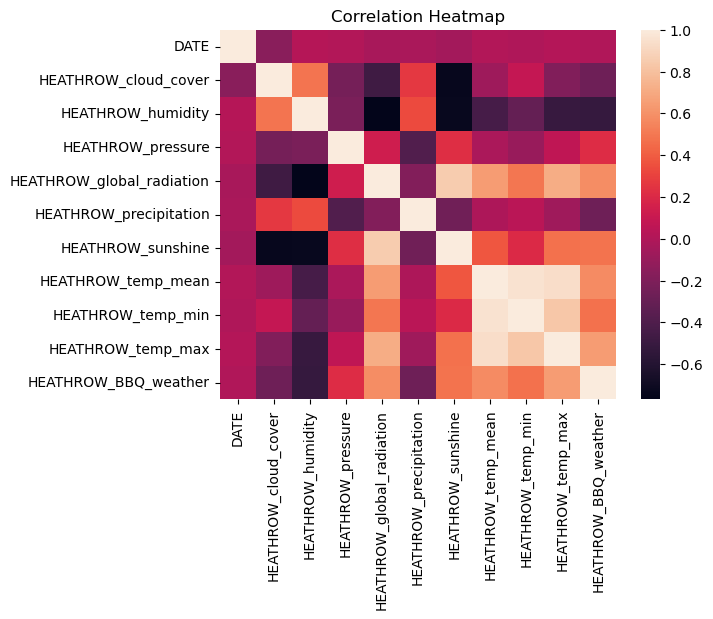

In [21]:
# heatmap
sns.heatmap(base_df_heathrow.corr()).set_title("Correlation Heatmap");

By observing the correlation table and heatmap, it is clear that mean, min, and max temperature are highly correlated, which is no surprise. Sunshine and humidity, and sunshine and cloud cover have strong negative correlations, which again would be expected.

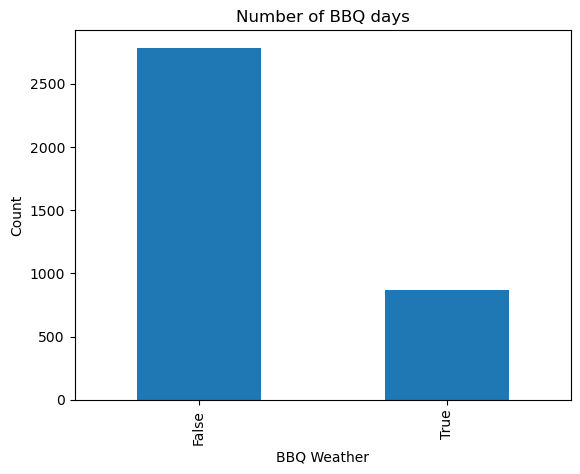

In [22]:
# barplot to visualize true and false ratios
base_df_heathrow['HEATHROW_BBQ_weather'].value_counts().plot.bar(title='Number of BBQ days', ylabel='Count').set_xlabel('BBQ Weather');

As noted earlier, False outcomes are about 3 times more common than True outcomes.

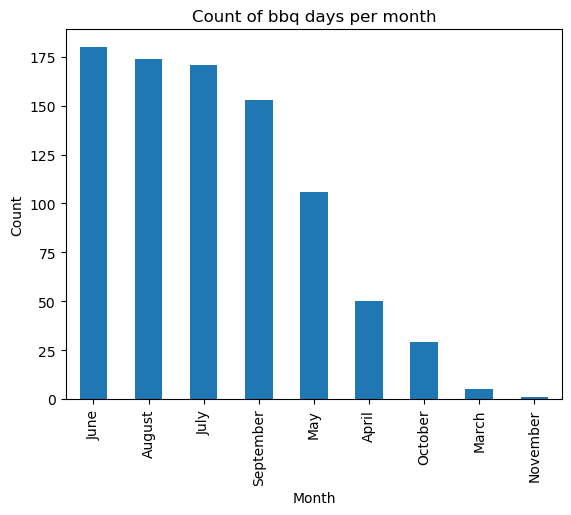

In [23]:
# plot number of good bbq weather days by month

bbq = base_df_heathrow.loc[base_df_heathrow['HEATHROW_BBQ_weather'] == True]
bbq['MONTH'].value_counts().plot.bar(title='Count of bbq days per month', ylabel='Count').set_xlabel('Month');

Not surprisingly, the summer months had by far the highest number of good bbq days. November and March had very few, and it appears that winter months- December, January, and February- had none.

In [24]:
base_df_heathrow.groupby('MONTH')['HEATHROW_BBQ_weather'].sum()

MONTH
April         50
August       174
December       0
February       0
January        0
July         171
June         180
March          5
May          106
November       1
October       29
September    153
Name: HEATHROW_BBQ_weather, dtype: int64

For the entire dataset, December, January, and February had no good bbq days. Novermber had only one, and March had only 5.

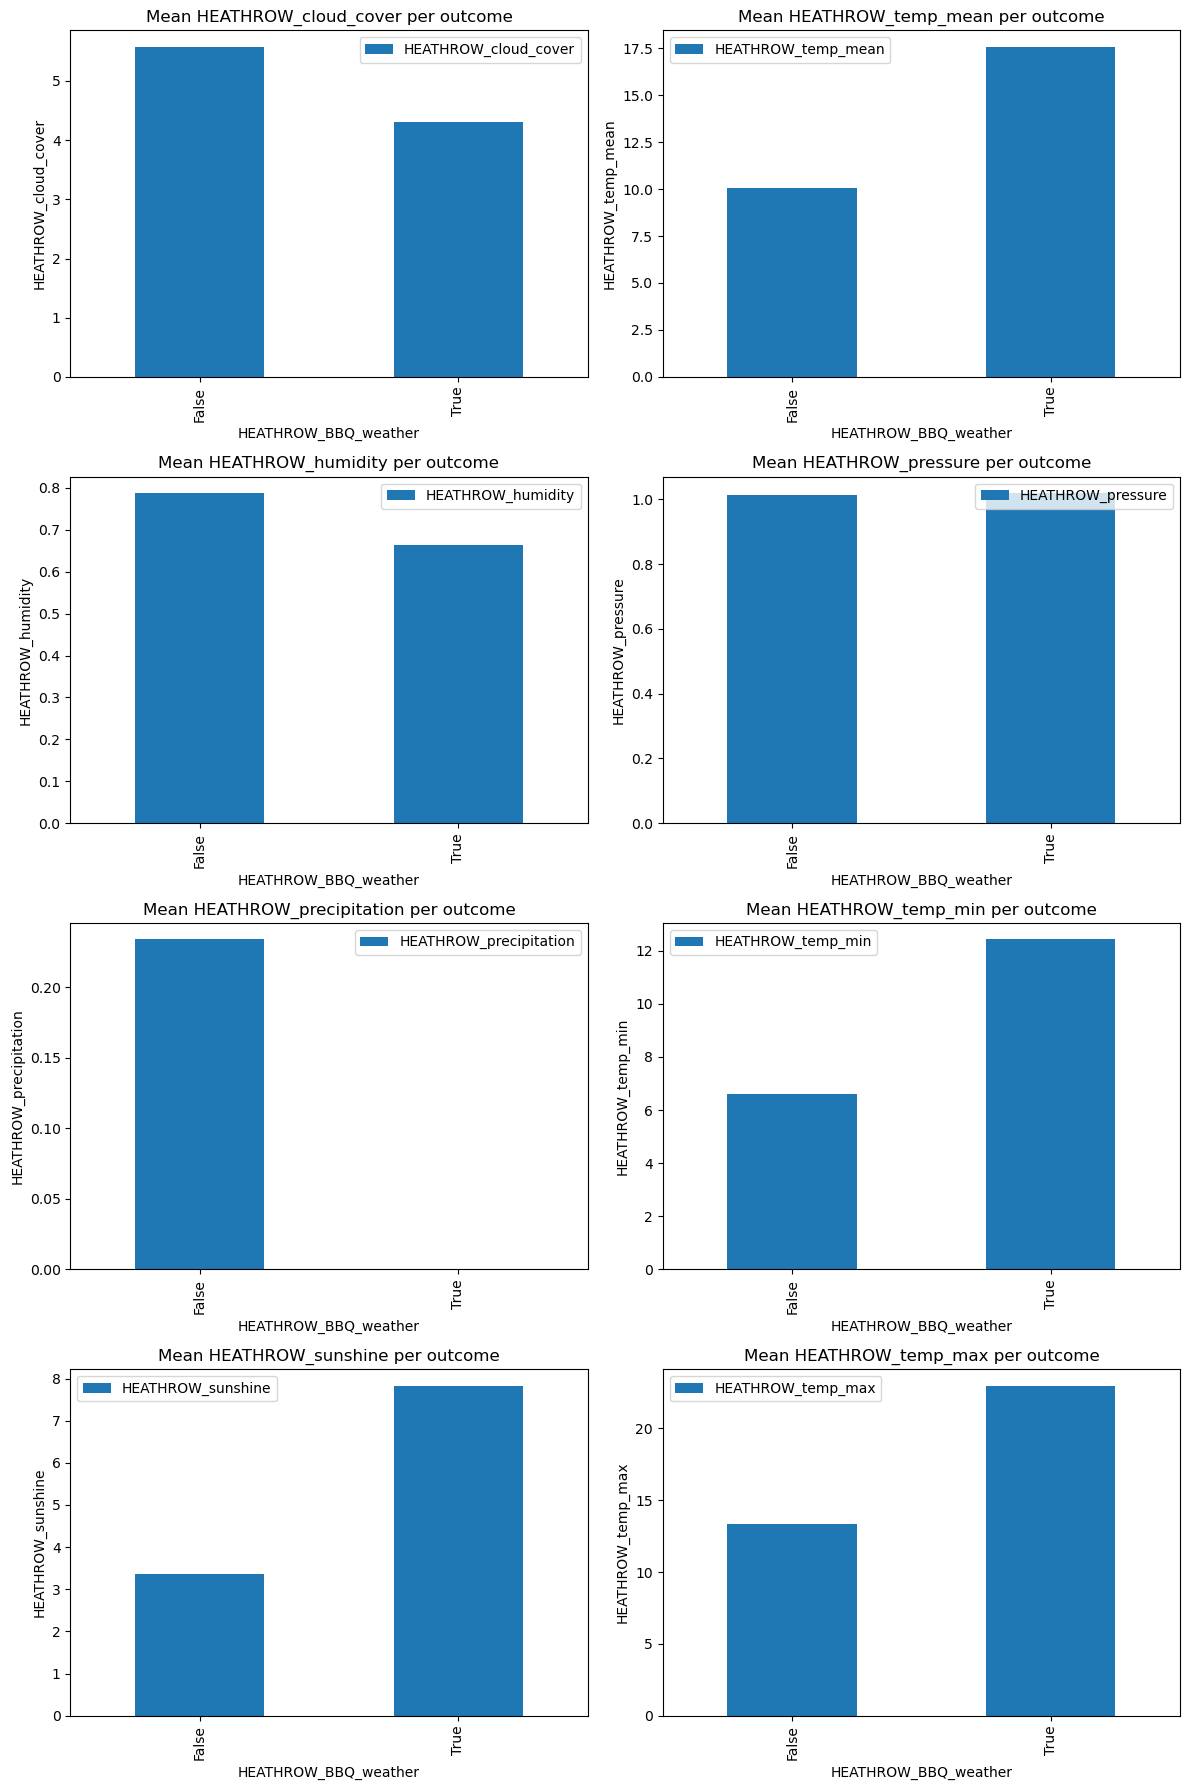

In [25]:
# visualize column data per outcome

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,18))
for i, col in enumerate(['HEATHROW_cloud_cover', 'HEATHROW_humidity', 'HEATHROW_precipitation', 'HEATHROW_sunshine', 'HEATHROW_temp_mean', 'HEATHROW_pressure', 'HEATHROW_temp_min', 'HEATHROW_temp_max']):
    base_df_heathrow.groupby('HEATHROW_BBQ_weather').mean().plot.bar(y=col, ylabel=col, title= 'Mean ' + col + ' per outcome', ax=axes[i%4][i//4]);
plt.tight_layout();

Just from observing the plots, it is obvious precipitation plays a huge role. Temperature and sunshine also look to play a significant role, while cloud cover and pressure do not seem to affect the outcome much. 

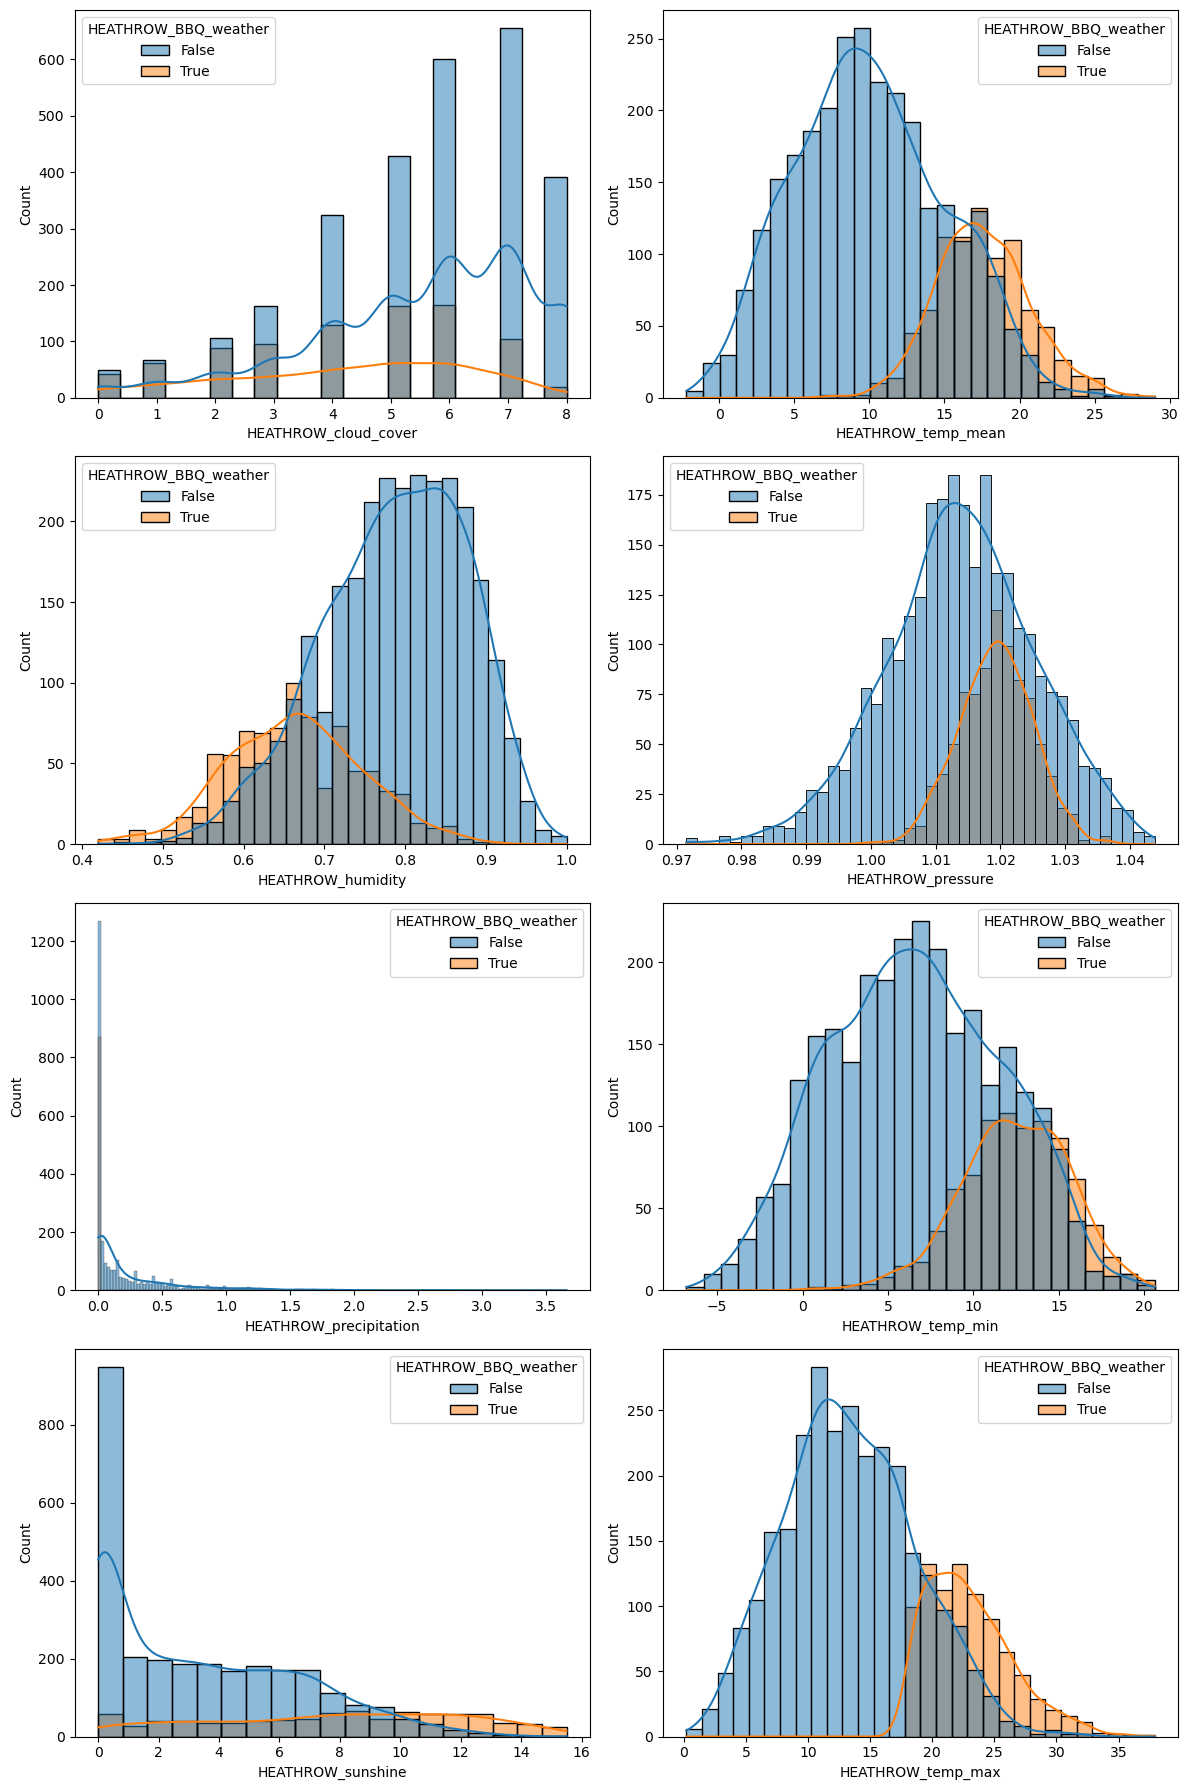

In [26]:
#histogram of data for True and False outcomes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,18))
for i, col in enumerate(['HEATHROW_cloud_cover', 'HEATHROW_humidity', 'HEATHROW_precipitation', 'HEATHROW_sunshine', 'HEATHROW_temp_mean', 'HEATHROW_pressure', 'HEATHROW_temp_min', 'HEATHROW_temp_max']):
    sns.histplot(data=base_df_heathrow, x=col, hue="HEATHROW_BBQ_weather", kde=True, ax=axes[i%4][i//4])
plt.tight_layout();

Again, precipitation, temperature, and humidity appear noticeably different per outcome. I would expect these features to be important for determining outcomes in the modeling process.

# Modeling

I am now going to investigate different types of models and evaluate their performance. First, I need to make dummy columns for each month, define X and y, and subsequently split the data into training and test sets before proceding. 

In [27]:
# get dummy columns for month
df_heathrow = pd.get_dummies(base_df_heathrow)
df_heathrow.head()

,DATE,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,...,MONTH_December,MONTH_February,MONTH_January,MONTH_July,MONTH_June,MONTH_March,MONTH_May,MONTH_November,MONTH_October,MONTH_September
0,20000101,7,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8,...,0,0,1,0,0,0,0,0,0,0
1,20000102,7,0.89,1.0253,0.20,0.02,0.7,7.9,5.0,11.5,...,0,0,1,0,0,0,0,0,0,0
2,20000103,8,0.91,1.0186,0.13,0.60,0.0,9.4,7.2,9.5,...,0,0,1,0,0,0,0,0,0,0
3,20000104,5,0.89,1.0148,0.34,0.02,2.9,7.0,4.4,11.0,...,0,0,1,0,0,0,0,0,0,0
4,20000105,5,0.85,1.0142,0.25,0.08,1.3,6.4,1.9,10.8,...,0,0,1,0,0,0,0,0,0,0


In [28]:
# define X and y
X = df_heathrow.drop(['DATE', 'HEATHROW_BBQ_weather'],axis=1)
y = df_heathrow['HEATHROW_BBQ_weather']

#### Train-test split

In [29]:
# split data into train and test sets. 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

The data is now ready for classification modeling.

### Basic logistic regression model

In [30]:
# instantiate model 

logreg = LogisticRegression(fit_intercept=False, C=1, solver='liblinear')

# Fit to training data
log_model = logreg.fit(X_train, y_train)
log_model

LogisticRegression(C=1, fit_intercept=False, solver='liblinear')

#### Model evaluation

In [31]:
# get predicted y values and evaluate

log_model_y_pred = log_model.predict(X_test)

print(classification_report(y_test, log_model_y_pred))
print("F1 score: ", f1_score(y_test, log_model_y_pred))

              precision    recall  f1-score   support

       False       0.94      0.97      0.96       548
        True       0.90      0.83      0.86       183

    accuracy                           0.93       731
   macro avg       0.92      0.90      0.91       731
weighted avg       0.93      0.93      0.93       731

F1 score:  0.8628571428571429


The basic logistic regression model has an F1 score of 0.86 and precision of 0.9. These are overall good scores, but can certainly be improved upon. 

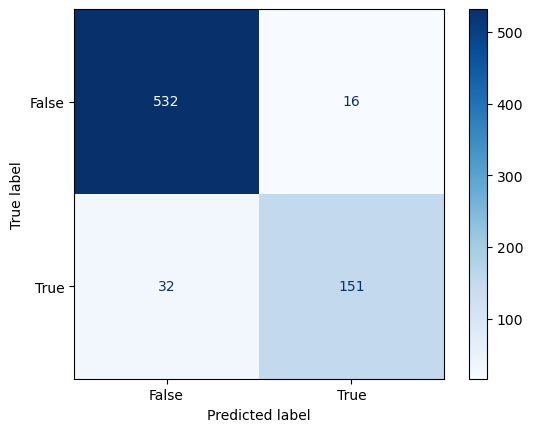

In [32]:
# plot confusion matrix
cnf_matrix = confusion_matrix(y_test, log_model_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=log_model.classes_)
disp.plot(cmap=plt.cm.Blues);

From the confusion matrix, it can be seen that of the 548 False outcomes, 532 were correctly predicted, and that of the 183 True outcomes, 151 were correctly predicted. There were 16 false positives and 32 false negatives. 

In [33]:
# investigate AUC for train and test data

log_model_y_test_score = logreg.decision_function(X_test)
log_model_y_pred = log_model.predict(X_test)
log_model_test_fpr, log_model_test_tpr, log_model_test_thresholds = roc_curve(y_test, log_model_y_test_score)


print(auc(log_model_test_fpr, log_model_test_tpr))



0.9835566989749113


The AUC score is nearly perfect. However, as the dataset is somewhat imbalanced, AUC may not be the best metric.

In [34]:
c_vals = [1, 5, 10, 50, 100]
best_C = None 
best_score = 0.0

for n in c_vals:
    
    logreg = LogisticRegression(fit_intercept=False, C=n, solver='liblinear')
    lr_model = logreg.fit(X_train, y_train)
    
    y_pred = lr_model.predict(X_test)
    f1 =  f1_score(y_test, y_pred)
    print("C value:", n, ". F1 score: ", f1)
    if f1 > best_score:
        best_C = n
        best_score = f1
    

print("\n" "Best C value: ", best_C, ". Best f1 score ", best_score)

C value: 1 . F1 score:  0.8628571428571429
C value: 5 . F1 score:  0.8926553672316384
C value: 10 . F1 score:  0.9070422535211268
C value: 50 . F1 score:  0.9411764705882353
C value: 100 . F1 score:  0.9526462395543176

Best C value:  100 . Best f1 score  0.9526462395543176


Increasing C (less regularization and more value to training data) seems to have increase performance. 

In [35]:
# instantiate model 

logreg2 = LogisticRegression(fit_intercept=False, C=100, solver='liblinear')

# Fit to training data
log_model2 = logreg2.fit(X_train, y_train)
log_model2

LogisticRegression(C=100, fit_intercept=False, solver='liblinear')

#### Model evaluation

In [36]:
# get predicted y values and evaluate

log_model2_y_pred = log_model2.predict(X_test)

print(classification_report(y_test, log_model2_y_pred))
print("F1 score: ", f1_score(y_test, log_model2_y_pred))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98       548
        True       0.97      0.93      0.95       183

    accuracy                           0.98       731
   macro avg       0.97      0.96      0.97       731
weighted avg       0.98      0.98      0.98       731

F1 score:  0.9526462395543176


The basic logistic regression model has an F1 score of 0.86 and precision of 0.9. These are overall good scores, but can certainly be improved upon. 

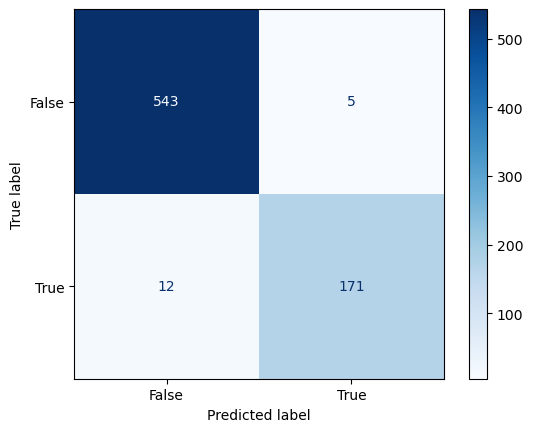

In [37]:
log2_cnf_matrix = confusion_matrix(y_test, log_model2_y_pred)
log2_disp = ConfusionMatrixDisplay(confusion_matrix=log2_cnf_matrix, display_labels=log_model2.classes_)
log2_disp.plot(cmap=plt.cm.Blues);

Compared with the baseline logistic regression model, this one only incorrectly predicted 5 false positives and 12 false negatives. 

I will now investigate other types of models. If all other models perform pooror than the logistic regression, I will return to it and experiment with altering the penalty type or solver.

### K-Nearest Neighbors

Next I will look at a K-Nearest Neighbors (KNN) model. The KNN algorithm examines the labels of a chosen number of known data points surrounding a target data point, in order to make a prediction about the class that the target data point falls into. Because it is based on distance, it is important to first standardize the data. 

In [38]:
# data must be scaled
scaler = StandardScaler()

# Transform the training and test sets
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_X_train, columns=X.columns)
scaled_df_train.head()

,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,MONTH_April,...,MONTH_December,MONTH_February,MONTH_January,MONTH_July,MONTH_June,MONTH_March,MONTH_May,MONTH_November,MONTH_October,MONTH_September
0,0.870739,0.798819,-0.752802,-0.425281,-0.366392,-1.014606,0.463634,0.845271,0.119255,-0.297726,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,-0.301793,-0.307159,-0.296362,-0.304484,-0.306492
1,-0.120564,-0.171650,-2.758235,-0.504851,-0.204199,-0.712971,-0.319709,-0.530019,-0.239577,-0.297726,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,3.313534,-0.307159,-0.296362,-0.304484,-0.306492
2,-1.607518,-1.918495,0.019243,1.291168,-0.474521,1.850919,-0.853807,-1.370474,-0.379990,3.358796,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,-0.301793,-0.307159,-0.296362,-0.304484,-0.306492
3,0.870739,0.022444,-0.263213,-0.766297,-0.474521,-0.134839,-0.123874,0.176727,-0.801227,-0.297726,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,-0.301793,-0.307159,3.374254,-0.304484,-0.306492
4,0.375088,1.284054,1.214970,-1.027743,-0.474521,-1.014606,-0.925020,-1.294069,-0.582808,-0.297726,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,-0.301793,-0.307159,3.374254,-0.304484,-0.306492


In [39]:
# instantiate KNN model
knn = KNeighborsClassifier()

# Fit the classifier
knn.fit(scaled_X_train, y_train)



KNeighborsClassifier()

#### Model evaluation

In [40]:
# Predict on the test set and evaluate
knn_test_preds = knn.predict(scaled_X_test)

print(classification_report(y_test, knn_test_preds))

print("F1 score: ", f1_score(y_test, knn_test_preds))

              precision    recall  f1-score   support

       False       0.94      0.94      0.94       548
        True       0.83      0.81      0.82       183

    accuracy                           0.91       731
   macro avg       0.88      0.88      0.88       731
weighted avg       0.91      0.91      0.91       731

F1 score:  0.8176795580110497


The F1 score of 0.82 and precision of 0.83 are lower than the basic logistic regression model. Perhaps altering some parameters will imporove model performance.

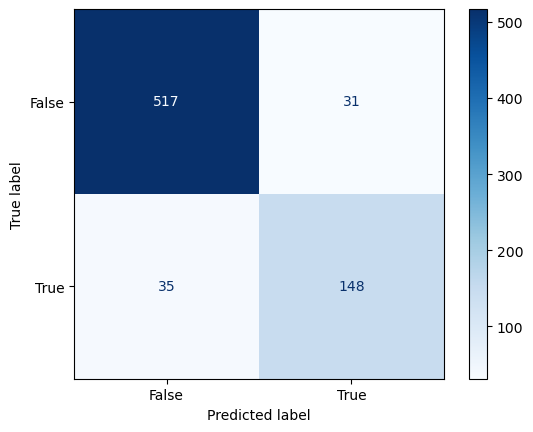

In [41]:
knn_cnf_matrix = confusion_matrix(y_test, knn_test_preds)
knn_disp = ConfusionMatrixDisplay(confusion_matrix=knn_cnf_matrix, display_labels=knn.classes_)
knn_disp.plot(cmap=plt.cm.Blues);

With 31 false positives and 35 false negatives, it is evident the baseline KNN model is not as performant as the logistic regression models.

In [42]:
# Check the AUC of predictions
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_test_preds)
knn_auc = auc(knn_fpr, knn_tpr)
knn_auc

0.8760869131666069

As could be expected, the AUC score is also lower than the logistic regression models. I would like to see if finding an optimal value for K, the number of neighbors the algorithm will use in determining the value of the target, will improve model performance.

In [43]:
# iterate over k values and find best model

k_vals = range(1, 25, 2)
best_k = 0
best_score = 0.0
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(scaled_X_train, y_train)
    preds = knn.predict(scaled_X_test)
        
    f1 = f1_score(y_test, preds)
    
    if f1 > best_score:
        best_k = k
        best_score = f1
        
    
print("Best Value for k: {}".format(best_k))
print("F1-Score: {}".format(best_score))


Best Value for k: 7
F1-Score: 0.8453038674033149


A value of 7 for the number of neighbors produced the highest F1 score. This is barely an improvement from the first knn model and lower than any logistic regression models. 

In [44]:
knn2 = KNeighborsClassifier(n_neighbors=7)

# Fit the classifier
knn2.fit(scaled_X_train, y_train)


# Predict on the test set
knn2_test_preds = knn2.predict(scaled_X_test)

In [45]:
print(classification_report(y_test, knn2_test_preds))

              precision    recall  f1-score   support

       False       0.95      0.95      0.95       548
        True       0.85      0.84      0.85       183

    accuracy                           0.92       731
   macro avg       0.90      0.89      0.90       731
weighted avg       0.92      0.92      0.92       731



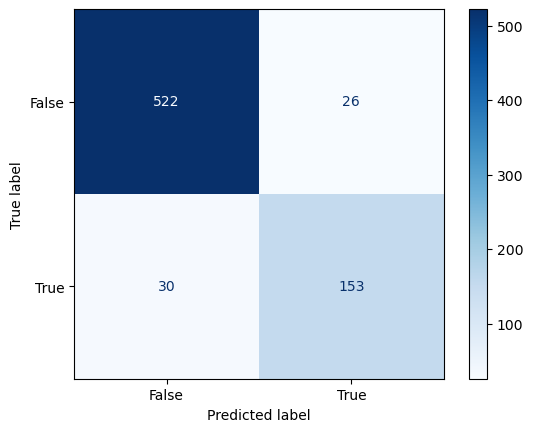

In [46]:
knn2_cnf_matrix = confusion_matrix(y_test, knn2_test_preds)
knn2_disp = ConfusionMatrixDisplay(confusion_matrix=knn2_cnf_matrix, display_labels=knn2.classes_)
knn2_disp.plot(cmap=plt.cm.Blues);

In [47]:
# Check the AUC of predictions
knn2_fpr, knn2_tpr, knn2_thresholds = roc_curve(y_test, knn2_test_preds)
knn2_auc = auc(knn2_fpr, knn2_tpr)
knn2_auc

0.8943101591480196

Considering the multiple classification metrics, KNN does not seem to be as good of a model. 

### Basic decision tree classifier

A decision tree is a hierarchical, flowchart-like structure in which each internal node represents a feature, each branch a possible attribute of the feature, and each leaf node represents a possible outcome. 

In [48]:
# instantiate model
dt = DecisionTreeClassifier()

#fit to training data
dt.fit(X_train, y_train)

DecisionTreeClassifier()

#### Model evaluation

In [49]:
# predict y values and evaluate

dt_y_pred = dt.predict(X_test)

print(classification_report(y_test, dt_y_pred))
print("F1 score: ", f1_score(y_test, dt_y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       548
        True       1.00      1.00      1.00       183

    accuracy                           1.00       731
   macro avg       1.00      1.00      1.00       731
weighted avg       1.00      1.00      1.00       731

F1 score:  1.0


This model has a perfect F1 score on the dataset. While perfect scores can happen, I should be suspicious, as this is rarely the case.

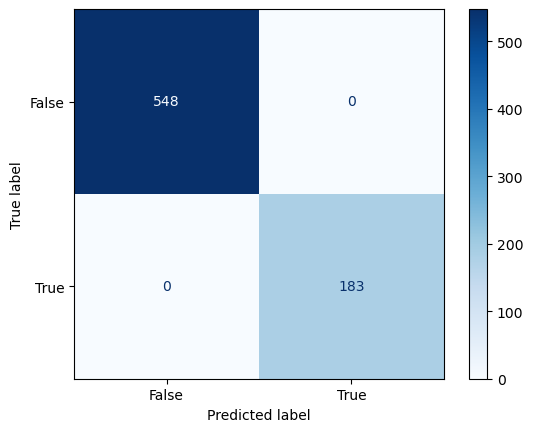

In [50]:
dt_cnf_matrix = confusion_matrix(y_test, dt_y_pred)
dt_disp = ConfusionMatrixDisplay(confusion_matrix=dt_cnf_matrix, display_labels=dt.classes_)
dt_disp.plot(cmap=plt.cm.Blues);

The confusion matrix also demonstrates that the basic decesion tree correctly predicted every outcome. 

In [51]:
# Check the AUC 
dt_fpr, dt_tpr, thresholds = roc_curve(y_test, dt_y_pred)
dt_auc = auc(dt_fpr, dt_tpr)
dt_auc

1.0

The AUC is also perfect. I am now going to visually inspect the tree to make sure nothing seems extremely odd.

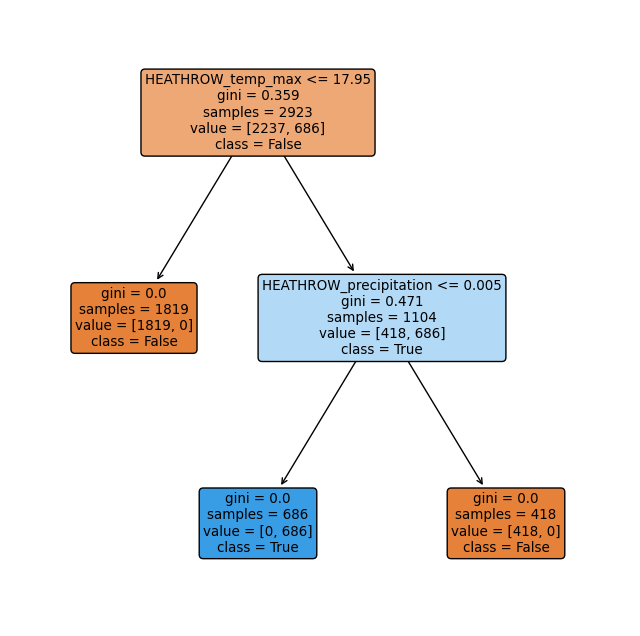

In [52]:
# Plot and show decision tree
plt.figure(figsize=(8, 8))
tree.plot_tree(dt, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

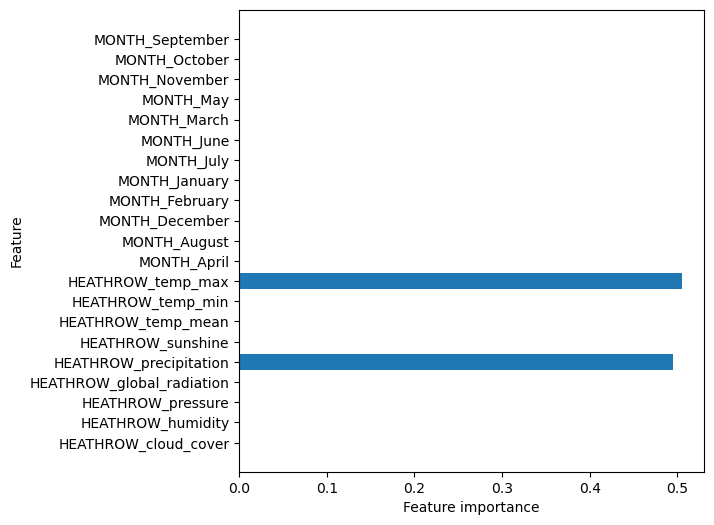

In [53]:
# plot the feature importances

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(6,6))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(dt)

Max temperature and precipitation amount appear to be the deciding factors in whether or not it will be suitable for an outdoor bbq. Considering the bar charts above in which min, mean, and max temperature, as well as precipitation and sunshine, seemed to influence the outcome, this is not particularily surprising. Min, mean, and max temperature are all highly correlated, as are precipitation and sunshine. I am interested to find out if other variables besides precipitation and temperature have importance in more complex models.

### Random forest classifier

I am now going to look at a random forest model. A random forest algorithm is essentially an ensemble of decision trees. Each tree is given a random subset of features to use as predictors for each node when training a decision tree, instead of using all predictors available at each node. Thus, not all trees "know" about max temp or precipitation.

In [54]:
# instantiate and fit model

forest = RandomForestClassifier()

forest.fit(X_train, y_train)

RandomForestClassifier()

#### Model evaluation

In [55]:
# predict and evaluate

forest_y_pred = forest.predict(X_test)

print(classification_report(y_test, forest_y_pred))
print("F1 score: ", f1_score(y_test, forest_y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       548
        True       1.00      1.00      1.00       183

    accuracy                           1.00       731
   macro avg       1.00      1.00      1.00       731
weighted avg       1.00      1.00      1.00       731

F1 score:  1.0


As could be expected based on the basic decesion tree, this model also has a perfect f1 score. 

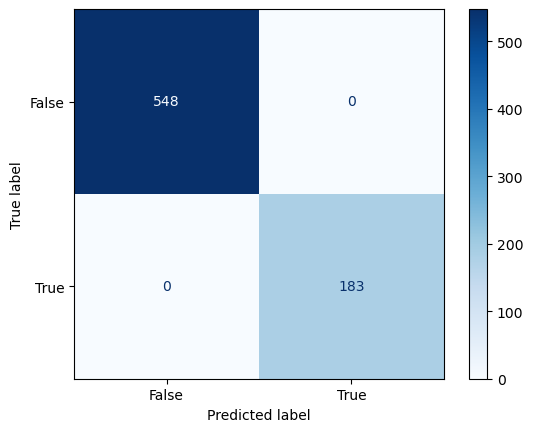

In [56]:
rf_cnf_matrix = confusion_matrix(y_test, forest_y_pred)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cnf_matrix, display_labels=forest.classes_)
rf_disp.plot(cmap=plt.cm.Blues);

In [57]:
# AUC 
forest_fpr, forest_tpr, thresholds = roc_curve(y_test, forest_y_pred)
forest_auc = auc(forest_fpr, forest_tpr)
forest_auc

1.0

The random forest model is also a great model for this specific dataset. Next, I am going to look at the most important features, which I expect there to be more of than the basic model, since that not all trees were given the two primary features.

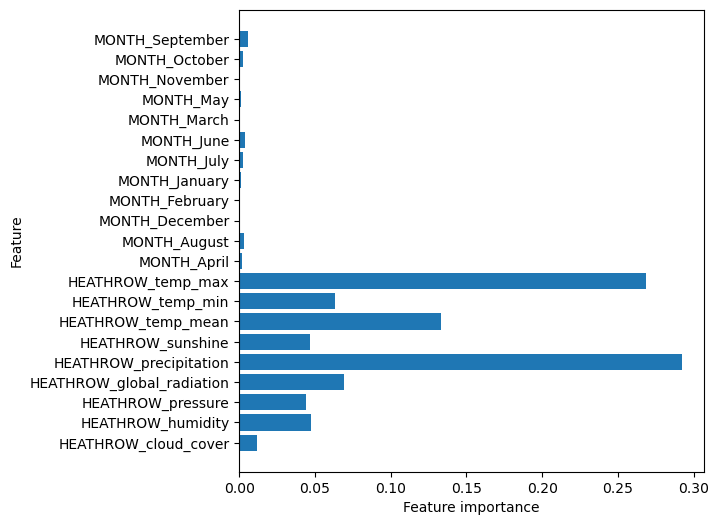

In [58]:
# plot feature importances
plot_feature_importances(forest)

Max temp and precipitation are still by far the most important. However, since not all trees were given these two features, it is now apparent that other features have some importance-  humidity, sunshine, and radiation had noteable impacts, as did mean and min temperature. 

#### Random Forest using grid search to find optimal parameters

I am curious if a grid search will have any different results among feature importances.

In [59]:
# define the param grid and conduct a grid search

grid = {
    'n_estimators': [10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
forest_grid_search = GridSearchCV(forest, grid, cv=3)
forest_grid_search.fit(X_train, y_train)


print(f"Optimal Parameters: {forest_grid_search.best_params_}")

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


The optimal parameters according to the grid search are slightly different than the random forest with default parameters- the criterion was entropy (default is gini) and min_samples_leaf was 2 (default is 5).

In [60]:
# evaluate best model parameters
best_rf = RandomForestClassifier(criterion='entropy',  max_depth= None, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100)
best_rf.fit(X_train, y_train)
best_rf_y_pred = best_rf.predict(X_test)

print(classification_report(y_test, best_rf_y_pred))
print("F1 score: ", f1_score(y_test, best_rf_y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       548
        True       1.00      1.00      1.00       183

    accuracy                           1.00       731
   macro avg       1.00      1.00      1.00       731
weighted avg       1.00      1.00      1.00       731

F1 score:  1.0


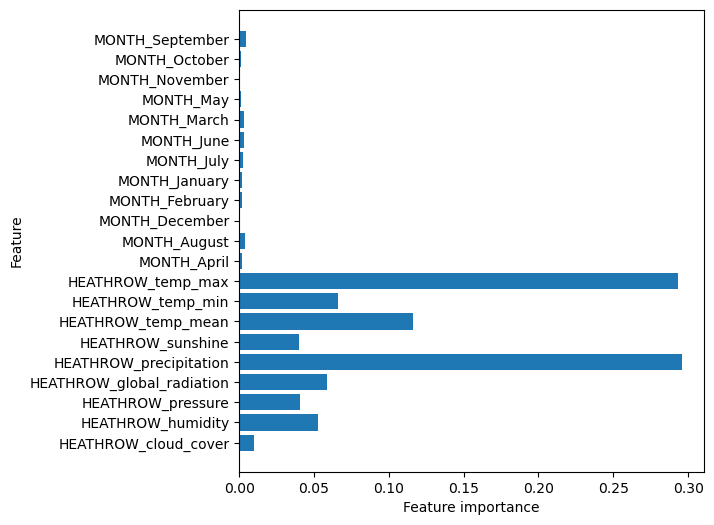

In [61]:
plot_feature_importances(best_rf)

There is hardly a difference in feature importance when compared with the initial random forest model- the only noticeable change is that sunshine looks slightly less important, especially in comparison to radiation. 

### Using Shap to visualize the influence of  features on the Random Rorest model

The interactive SHAP plot below explains which features had the most influence on the model’s for each individual data point in the training set.
Features in red indicate that specific value pushed the prediction towards a positive outcome, and features in blue a negative outcome.

In [ ]:
# make explainer and calculate shap values
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

# visualize the explanation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_train.iloc[0:])

Upon examining many of the data points, it is clear that very small values for precipitation amounts and max temperatures above (approximately) 18 degrees Celsius contribute to a positive outcome. Lower temperatures and significant precipitation are associated with the opposite. Humidity shows up in a number of points- values above .85 push towards a negative outcome, while higher values of sunshine (>13) show up in positive outcomes. 

# Evaluation

The basic decision tree model, and subsequent more complex models based off decision trees- the random forest and grid search tuned random forest- far outperformed the logistic regression and K-Nearest Neighbors models. All the models based off decision trees had an F1 score of 1, which indicated those models perfectly predicted every outcome. The best logistic regression model had an F1 score of .95, while the best KNN model was only .84.

While decision trees can often tend to overfit training data and be more affected by outliers, in this case the decision tree performed just as well as the more complex models. Since a random forest or bagged tree is much more computationally expensive than a simple decision tree, in this case the decision tree is the best model in terms of overall performance and efficiency. 

# Conclusions

*  The basic decision tree is the best model for accurately predicting good bbq weather. 


*  Max temperature and precipitation are by far the most important factors to consider when deciding whether or not to fire up the outdoor charcoal grills. 


*  Check the forecast, ideally the morning of, and make a call based on the temperature and precipitation forecasts. 


*  Finally, due to there being almost no good days November-March, consider closing the outdoor area and tidying away the grills for the winter months.

# Next Steps and Limitations


*  Further research should be done to determine the relationship between "percent chance of precipitation" and outcome. 


*  Wind is likely to be a factor, but was not represented in this dataset. 


*  Finally, it is worth noting that the data is from over a decade ago- climate change and shifting weather patterns may influence current and future predictions. 
